## Convoluted Neural Network (CNN)
***Taha Adeel Mohammed - CS20BTECH11052***

Below Python code implements a generic Convolutional Neural Network (ANN) with variable number of convolutional and hidden layers and neurons in each layer. The code is very modular, and can be used on various supervised datasets.

### Assignement-3 Code
Below code is functionally equivalent to the code in the assignment-3, while being refactored to be more modular and generic.

#### Activation and Loss Functions

In [15]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import Callable
from tqdm.notebook import tqdm

np.set_printoptions(precision=3, suppress=True)
np.random.seed(27)

In [16]:
# Activation functions
def identity(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return np.ones_like(x)
    return x
    
def sigmoid(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

def tanh(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return 1 - tanh(x)**2
    return np.tanh(x)

def ReLU(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.where(x > 0, x, 0)

def PReLU(x: np.ndarray, alpha: float = 0.2, derivative: bool = False) -> np.ndarray:
    if derivative:
        return np.where(x > 0, 1, alpha)
    return np.where(x > 0, x, alpha * x)

def softmax(x: np.ndarray, derivative: bool = False) -> np.ndarray:
    if derivative:
        return softmax(x) * (1 - softmax(x))
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=1, keepdims=True)

# Loss functions
def squared_error_loss(y_true: np.ndarray, y_pred: np.ndarray, derivative: bool = False) -> float | np.ndarray:
    if derivative:
        return 2 * (y_pred - y_true)
    return np.sum((y_pred - y_true)**2)

#### Layer Classes

##### Base Layer Class

In [17]:
class Layer(ABC):
    '''Base class for all layers'''
    def __init__(self):
        self.input: np.ndarray | None = None
        self.output: np.ndarray | None = None
        
    @abstractmethod
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        '''Forward propagation of input through the layer'''
        raise NotImplementedError
    
    @abstractmethod
    def backward_propagation(self, output_error: np.ndarray) -> np.ndarray:
        '''Backward propagation of output error through the layer'''
        raise NotImplementedError
    
    @abstractmethod
    def update_parameters(self, learning_rate: float) -> None:
        '''Update the parameters of the layer'''
        raise NotImplementedError

##### Fully Connected Layer Class

In [18]:
class FullyConnectedLayer(Layer):
    '''Represents a fully connected layer (without the activation function)'''
    def __init__(self, input_size: int, num_nodes: int, bias: bool = True) -> None:
        # Add 1 to the input size for the bias
        self.bias: bool = bias
        self.weights: np.ndarray = np.random.rand(input_size + (1 if self.bias else 0), num_nodes) - 0.5
        self.weights_gradient: np.ndarray = np.zeros_like(self.weights)
        
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        input = np.atleast_2d(input)
        if self.bias:
            input = np.c_[np.ones((input.shape[0], 1)), input]
        
        self.input = input
        self.output = input @ self.weights
        return self.output
    
    def backward_propagation(self, output_error: np.ndarray) -> np.ndarray:
        self.weights_gradient += self.input.T @ output_error
        input_error = output_error @ self.weights.T[:, (1 if self.bias else 0):]
        return input_error
    
    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.weights_gradient
        self.weights_gradient = np.zeros_like(self.weights)
        
    def __str__(self) -> str:
        return f'Fully Connected Layer(input_size={self.weights.shape[0]}, num_neurons={self.weights.shape[1]}, bias={self.bias}, weights=\n{self.weights})'

##### Activation Layer Class

In [19]:
class ActivationLayer(Layer):
    '''Applies a non linear activation function to the output of the previous layer'''
    def __init__(self, activation: Callable = sigmoid):
        self.activation: Callable = activation
        
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        self.input = input
        self.output = self.activation(input)
        return self.output
    
    def backward_propagation(self, output_error: np.ndarray) -> np.ndarray:
        return output_error * self.activation(self.input, derivative=True)
    
    def update_parameters(self, learning_rate: float) -> None:
        pass
    
    def __str__(self) -> str:
        return f'Activation Layer(activation={self.activation.__name__})'

#### Network Class

In [20]:
class Network:
    '''Neural Network with multiple layers, implementing ANNs or CNNs'''
    
    def __init__(self) -> None:
        '''Initializes the network with no layers'''
        self.layers: list[Layer] = []
        
    def add(self, layer: Layer) -> None:
        '''Adds a layer to the network'''
        self.layers.append(layer)
        
    def use(self, loss: Callable = squared_error_loss) -> None:
        '''Sets the loss function to be used by the network'''
        self.loss: Callable = loss
        
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        '''Propagates the input through the network'''
        for layer in self.layers:
            input = layer.forward_propagation(input)
        return input
    
    def backward_propagation(self, output_error: np.ndarray) -> None:
        '''Propagates the output error through the network, updating the weight gradients of each layer'''
        for layer in reversed(self.layers):
            output_error = layer.backward_propagation(output_error)
    
    def predict(self, input_dataset: np.ndarray) -> np.ndarray:
        '''Predicts the output for the given input dataset'''
        input_dataset = np.atleast_2d(input_dataset)
        output = []
        for input in input_dataset:
            output.append(self.forward_propagation(input))
        return np.array(output).reshape(input_dataset.shape[0], -1)
    
    def fit(self,
            input_dataset: np.ndarray,
            output_dataset: np.ndarray,
            max_epochs: int,
            learning_rate: float,
            optimizer: str = 'SGD',
            batch_size: int = 1,
            convergence_threshold: float = 1e-6,
            verbose: bool = False) -> None:    
        '''Trains the network on the given dataset'''
        num_samples = input_dataset.shape[0]
        losses = []
        
        # Train for the given number of epochs
        for iteration in tqdm(range(max_epochs+1), desc='Training', colour='green'):
            # Randomly select a batch of samples from the training dataset
            batch_indices = np.random.choice(num_samples, batch_size, replace=False)
            X_batch, Y_batch = input_dataset[batch_indices], output_dataset[batch_indices]
            
            # Run forward and backward propagation on the batch to get the gradients
            for xi, yi in zip(X_batch, Y_batch):
                self.forward_propagation(xi)
                self.backward_propagation(self.loss(yi, self.layers[-1].output, derivative=True))
            
            # Update learning rate if optimizer is AdaGrad
            # TODO
            
            # Update the weights of the layers
            for layer in self.layers:
                layer.update_parameters(learning_rate)
                
            # Calculate the loss on the entire dataset
            Y_pred = self.predict(input_dataset)
            loss = np.sum(self.loss(output_dataset, Y_pred))
            losses.append(loss)
            
            # Print the loss
            if verbose and (iteration) % 200 == 0:
                print(f'Epoch {iteration}/{max_epochs} | Loss: {loss}')
            
            # Check for convergence
            if iteration > 0 and abs(losses[-1] - losses[-2]) < convergence_threshold:
                break
            
            
    def display_outputs(self, input: np.ndarray | None = None) -> None:
        '''Displays the outputs of each layer for the given input'''
        if input is not None: self.forward_propagation(input)
        else: input = self.layers[0].input
        
        print(f'Input: {self.layers[0].input.T}')
        for i, layer in enumerate(self.layers):
            print(f'Layer {i+1}: {layer.output.T}')
            
    def __str__(self) -> str:
        '''Prints the network layers and parameters'''
        desc = f'\nNetwork with {len(self.layers)} layers:'
        for i, layer in enumerate(self.layers):
            desc += f'\nLayer {i+1}: {layer}\n'
        return desc

#### ANN Test

In [21]:
def test_ann():
    # Initialize the XOR ANN
    xor_ann = Network()
    xor_ann.add(FullyConnectedLayer(input_size=2, num_nodes=2)) # Hidden layer
    xor_ann.add(ActivationLayer(sigmoid))
    xor_ann.add(FullyConnectedLayer(input_size=2, num_nodes=1)) # Output layer
    xor_ann.add(ActivationLayer(sigmoid))

    # Generate training data
    X, Y = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]), np.array([[0], [1], [1], [0]])

    # Train the network
    xor_ann.use(squared_error_loss)
    xor_ann.fit(X, Y, max_epochs=1000, learning_rate=0.7, batch_size=4, convergence_threshold=0, verbose=True)

    # Display the outputs
    Y_pred = xor_ann.predict(X)
    print(f'\nPredictions: {Y_pred.T}')
    print(f'Real: {Y.T}')
    print(f'Final Loss: {xor_ann.loss(Y, Y_pred)}\n')

    print(xor_ann)
    
test_ann()

Training:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 0/1000 | Loss: 1.0076132910560647
Epoch 200/1000 | Loss: 0.9787812439200841
Epoch 400/1000 | Loss: 0.223055366873876
Epoch 600/1000 | Loss: 0.025399642589527156
Epoch 800/1000 | Loss: 0.011868015630005852
Epoch 1000/1000 | Loss: 0.007561398949797972

Predictions: [[0.046 0.958 0.958 0.044]]
Real: [[0 1 1 0]]
Final Loss: 0.007561398949797972


Network with 4 layers:
Layer 1: Fully Connected Layer(input_size=3, num_neurons=2, bias=True, weights=
[[-6.008 -2.525]
 [ 3.917  5.925]
 [ 3.913  5.904]])

Layer 2: Activation Layer(activation=sigmoid)

Layer 3: Fully Connected Layer(input_size=3, num_neurons=1, bias=True, weights=
[[-3.591]
 [-8.614]
 [ 7.933]])

Layer 4: Activation Layer(activation=sigmoid)



### Assignment-4 Code
Added functionality to the code in assignment-3 to implement a Convolutional Neural Network (CNN).

#### Load CIFAR-10 Dataset

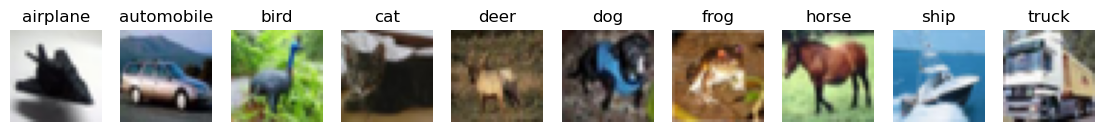

In [22]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

path = 'cifar-10-batches-py/data_batch_1'
dict = unpickle(path)
data = dict[b'data']
labels = dict[b'labels']
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

images_raw = [[] for _ in range(10)]
for i in range(10):
    images_raw[i] = data[np.where(np.array(labels) == i)]

# Store images as 32x32x3 array
images = [[] for _ in range(10)]
for i in range(10):
    for img in images_raw[i]:
        images[i].append(img.reshape(3, 32, 32).transpose(1, 2, 0))
        
# Display 10 images
fig, ax = plt.subplots(1, 10, figsize=(14, 5))
for i in range(10):
    ax[i].imshow(images[i][0])
    ax[i].set_title(label_names[i])
    ax[i].axis('off')
plt.show()

#### 1) Convolution function

In [23]:
def convolve(image: np.ndarray, kernel: np.ndarray, stride: tuple[int, int] = (1, 1), padding: tuple[int, int] = (0, 0), non_linearity_fn: Callable = identity, debug=False) -> np.ndarray:
    ''' Convolves the given image (volume) with the given kernel (volume)
    
    Args:
        image: The input image volume -> image.shape = (W, H, C) or (W, H)
        kernel: The kernel/filter (volume) used for convolution -> kernel.shape = (Wk, Hk, C) or (Wk, Hk)
        stride: The stride size -> (Sx, Sy)
        padding: The padding to be applied to the image -> (Px, Py)
        non_identity_fn: The non linearity function to be applied to the output of the convolution
        debug: Whether to print intermediate results or not
        
    Returns:
        The activation map after convolution -> output.shape = (Wo, Ho), where Wo = (W - Wk + 2Px) / Sx + 1 and Ho = (H - Hk + 2Py) / Sy + 1
    '''
    # Make 2D images and image volumes compatible
    assert image.ndim == kernel.ndim, 'Image and kernel must have the same number of dimensions'
    assert image.ndim in [2, 3], 'Image and kernel must be 2D or 3D'
    assert image.ndim == 2 or image.shape[-1] == kernel.shape[-1], 'Image and kernel must have the same number of channels'
    if image.ndim == 2:
        image = image[..., np.newaxis]
        kernel = kernel[..., np.newaxis]
        
    # Add padding to the image
    image = np.pad(image, [(padding[0], padding[0]), (padding[1], padding[1]), (0, 0)], mode='constant')
    if debug:
        print(f'Padded image:')
        for i in range(image.shape[-1]):
            print(f'Channel {i+1}:\n{image[..., i]}\n')
            
    # Initialize the output volume
    (W, H), (Wk, Hk), (Sx, Sy) = image.shape[:2], kernel.shape[:2], stride
    (Wo, Ho) = (W - Wk) // Sx + 1, (H - Hk) // Sy + 1
    output = np.zeros((Wo, Ho))
    
    # Perform convolution
    for i in range(Wo):
        for j in range(Ho):
            output[i, j] = np.sum(image[i*Sx:i*Sx+Wk, j*Sy:j*Sy+Hk, :] * kernel)
            
    if debug:
        print(f'Output before activation:\n{output}\n')
    
    return non_linearity_fn(output)

Image 1 from category airplane with shape (32, 32, 3) and
kernel with shape (3, 3, 3):
[[[-0.26   0.245  0.47 ]
  [ 0.198  0.454 -0.024]
  [ 0.097  0.411 -0.338]]

 [[-0.222 -0.153 -0.052]
  [-0.498  0.394  0.003]
  [ 0.234  0.439 -0.475]]

 [[-0.339  0.398  0.469]
  [-0.479 -0.032 -0.408]
  [-0.498 -0.094 -0.466]]]



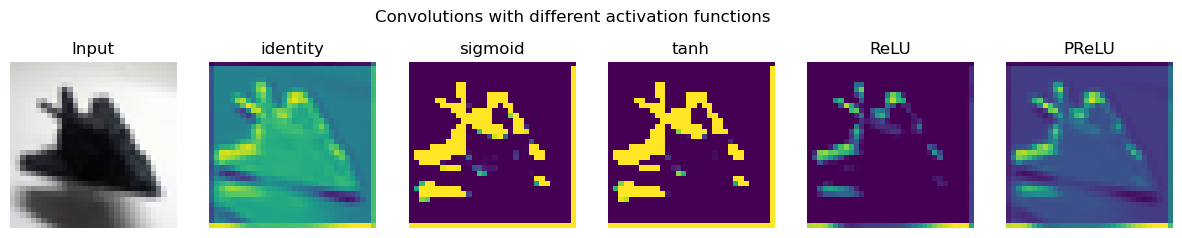

Image 2 from category cat with shape (32, 32, 3) and
kernel with shape (3, 3, 3):
[[[-0.149  0.436 -0.193]
  [-0.463 -0.469  0.027]
  [ 0.482 -0.088 -0.074]]

 [[ 0.368 -0.199 -0.236]
  [ 0.363  0.247 -0.265]
  [-0.428  0.306 -0.114]]

 [[ 0.181  0.262  0.033]
  [ 0.177 -0.056 -0.399]
  [ 0.383 -0.261 -0.293]]]



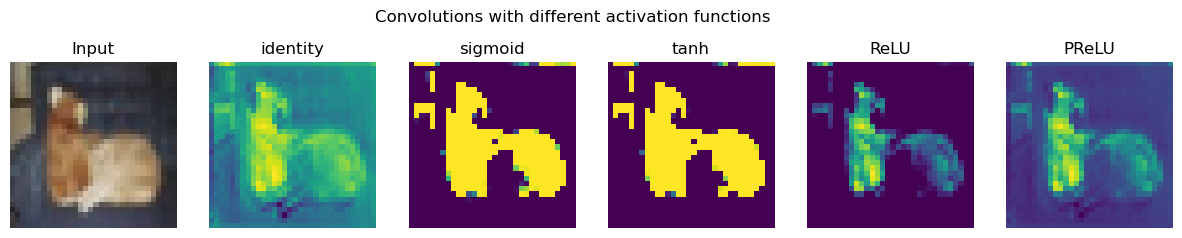

In [24]:
def test_convolve():
    test_images = [(0, 0), (3, 1)] # (category, index)
    test_activations = [identity, sigmoid, tanh, ReLU, PReLU]
    
    for category, index in test_images:
        image = images[category][index]
        kernel = np.random.rand(3, 3, 3) - 0.5
        
        print(f'Image {index+1} from category {label_names[category]} with shape {image.shape} and')
        print(f'kernel with shape {kernel.shape}:\n{kernel}\n')
        plt.figure(figsize=(15, 2.8))
        plt.suptitle(f'Convolutions with different activation functions')
        plt.subplot(1, 6, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Input')
        
        for i, activation in enumerate(test_activations):
            plt.subplot(1, 6, i+2)
            plt.imshow(convolve(image, kernel, non_linearity_fn=activation, stride=(1, 1), padding=(1, 1)))
            plt.title(activation.__name__)
            plt.axis('off')
        plt.show()
            

test_convolve()

#### 2) Pooling function

In [25]:
def pool(input: np.ndarray, pooling_size: tuple[int, int] = (2, 2), stride: tuple[int, int] = (2, 2), pooling_fn: Callable = np.max) -> np.ndarray:
    ''' Performs pooling on the an activation map to reduce its size
    
    Args:
        image: The activation map output by convolve() -> image.shape = (W, H)
        pooling_size: Size of the pooling window -> (Wp, Hp)
        stride: The stride size for the pooling window -> (Sx, Sy)
        pooling_fn: The pooling function to be applied for each window
        
    Returns:
        The pooled image -> output.shape = (Wo, Ho), where Wo = (W - Wp) / Sx + 1 and Ho = (H - Hp) / Sy + 1
    '''
    assert input.ndim == 2, 'Activation map must be 2D'
    
    # Initialize the output volume
    (W, H), (Wp, Hp), (Sx, Sy) = input.shape, pooling_size, stride
    (Wo, Ho) = (W - Wp) // Sx + 1, (H - Hp) // Sy + 1
    output = np.zeros((Wo, Ho))
    
    # Perform pooling
    for i in range(Wo):
        for j in range(Ho):
            output[i, j] = pooling_fn(input[i*Sx:i*Sx+Wp, j*Sy:j*Sy+Hp])
    
    return output

Singular channel image 6 from category bird with shape (32, 32)


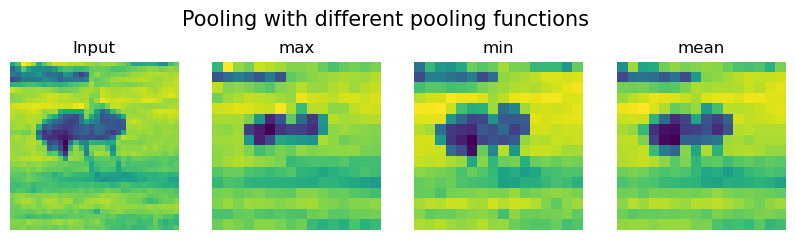

Singular channel image 2 from category frog with shape (32, 32)


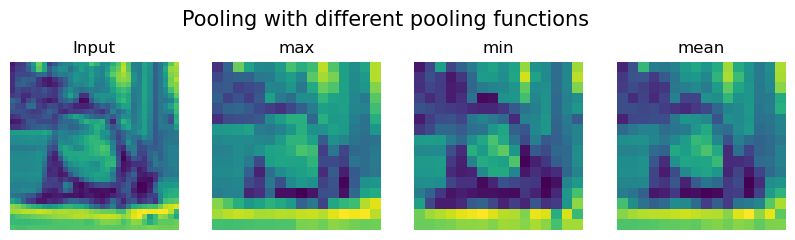

In [26]:
def test_pooling():
    test_images = [(2, 5), (6, 1)] # (category, index)
    test_pooling_fns = [np.max, np.min, np.mean]
    for category, index in test_images:
        image = images[category][index][..., 0]
        print(f'Singular channel image {index+1} from category {label_names[category]} with shape {image.shape}')
        plt.figure(figsize=(10, 2.8))
        plt.suptitle(f'Pooling with different pooling functions', fontsize=15)
        plt.subplot(1, 4, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Input')
        
        for i, pooling_fn in enumerate(test_pooling_fns):
            plt.subplot(1, 4, i+2)
            plt.imshow(pool(image, pooling_fn=pooling_fn))
            plt.title(pooling_fn.__name__)
            plt.axis('off')
        plt.show()

test_pooling()

#### 3) Convolutional layer function
The ConvolutionLayer class (extending Layer class) implemented below contains above required functionality in forward_propagation() method. 

In [27]:
class ConvolutionLayer(Layer):
    '''Represents a convolution layer, transforming the input activation/image volume into an output volume.'''
    def __init__(self, input_size: tuple[int, int, int], num_kernels: int, kernel_size: tuple[int, int, int], stride: tuple[int, int] = (1, 1), padding: tuple[int, int] = (0, 0), kernel_weights: np.ndarray | None = None) -> None:
        ''' Initializes the convolution layer
        
        Args:
            input_size: The size of the input activation/image volume -> (W, H, C)
            num_kernels: The number of kernels in the layer
            kernel_size: The size of the kernels -> (Wk, Hk, C)
            stride: The stride size -> (Sx, Sy)
            padding: The padding to be applied to the image -> (Px, Py)
            kernel_weights: The weights to be used for the kernels. If None, random weights are used -> shape = (Wk, Hk, C)
        '''
        self.input_size: tuple[int, int, int] = input_size
        self.num_kernels: int = num_kernels
        self.kernel_size: tuple[int, int] = kernel_size
        self.stride: tuple[int, int] = stride
        self.padding: tuple[int, int] = padding
        
        # Initialize the kernels
        if kernel_weights is not None:
            self.kernels: np.ndarray = np.array([kernel_weights] * num_kernels)
        else:
            self.kernels: np.ndarray = np.random.rand(num_kernels, kernel_size[0], kernel_size[1], kernel_size[2]) - 0.5
        self.kernels_gradient: np.ndarray = np.zeros_like(self.kernels)
        
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        '''Passes the input through the various kernels in the layer. Note that the output is not passed through an activation function, as passing it through an activation function is the job of the activation layer(Keeps the back prop simple)'''
        input = np.atleast_3d(input)
        assert input.shape == self.input_size, f'Input must be of shape {self.input_size} not {input.shape}'
        self.input = input
        self.output = np.zeros((input.shape[0], input.shape[1], self.num_kernels))
        for i in range(self.num_kernels):
            self.output[..., i] = convolve(input, self.kernels[i], stride=self.stride, padding=self.padding)
        return self.output
    
    def backward_propagation(self, output_error: np.ndarray) -> np.ndarray:
        return NotImplementedError
    
    def update_parameters(self, learning_rate: float) -> None:
        '''Updates the weights of the kernels'''
        self.kernels -= learning_rate * self.kernels_gradient
        self.kernels_gradient = np.zeros_like(self.kernels)
        
    def __str__(self) -> str:
        return f'Convolution Layer(input_size={self.input_size}, num_kernels={self.num_kernels}, kernel_size={self.kernel_size}, stride={self.stride}, padding={self.padding}, kernels=\n{self.kernels})'

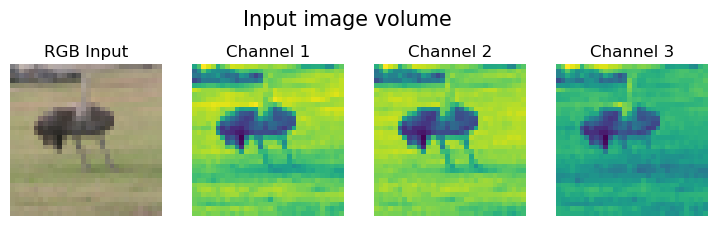

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


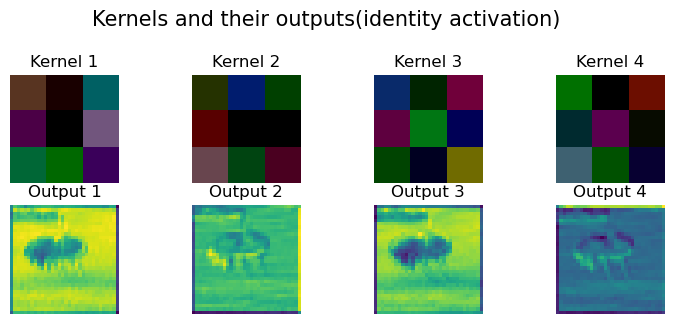

Output shape: (32, 32, 4)


In [28]:
def test_convolve_layer():
    test_image = images[2][5]
    test_layer = ConvolutionLayer(input_size=test_image.shape, num_kernels=4, kernel_size=(3, 3, 3), stride=(1, 1), padding=(1, 1))
    test_output = test_layer.forward_propagation(test_image)
    
    # Display the input image
    plt.figure(figsize=(9, 2.7))
    plt.suptitle(f'Input image volume', fontsize=15)
    
    plt.subplot(1, 4, 1)
    plt.imshow(test_image)
    plt.axis('off')
    plt.title('RGB Input')
    for i in range(test_image.shape[-1]):
        plt.subplot(1, 4, i+2)
        plt.imshow(test_image[..., i])
        plt.axis('off')
        plt.title(f'Channel {i+1}')
    plt.show()
    
    # Display the kernels and its output
    plt.figure(figsize=(9, 6.5))
    plt.suptitle(f'Kernels and their outputs(identity activation)', fontsize=15)
    for i in range(test_layer.num_kernels):
        plt.subplot(4, 4, i+1)
        plt.imshow(test_layer.kernels[i])
        plt.axis('off')
        plt.title(f'Kernel {i+1}')
        
        plt.subplot(4, 4, i+5)
        plt.imshow(test_output[..., i])
        plt.axis('off')
        plt.title(f'Output {i+1}')
    
    plt.show()
    print(f'Output shape: {test_output.shape}')
    assert test_output.shape == (test_image.shape[0], test_image.shape[1], test_layer.num_kernels), 'Output shape is incorrect'

test_convolve_layer()

#### 4) Pooling layer function
Similarly to ConvolutionLayer class, the PoolingLayer class (extending Layer class) implemented below contains above required functionality in forward_propagation() method.

In [29]:
class PoolingLayer(Layer):
    '''Represents a pooling layer, helping reduce the size of the activation volume.'''
    def __init__(self, input_size: tuple[int, int, int], pooling_size: tuple[int, int], stride: tuple[int, int] = (1, 1), pooling_fn: Callable = np.max) -> None:
        ''' Initializes the pooling layer
        
        Args:
            input_size: The size of the input activation/image volume -> (W, H, C)
            pooling_size: Size of the pooling window -> (Wp, Hp)
            stride: The stride size for the pooling window -> (Sx, Sy)
            pooling_fn: The pooling function to be applied for each window
        '''
        self.input_size: tuple[int, int, int] = input_size
        self.pooling_size: tuple[int, int] = pooling_size
        self.stride: tuple[int, int] = stride
        self.pooling_fn: Callable = pooling_fn
        
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        '''Passes the input through the pooling layer'''
        input = np.atleast_3d(input)
        assert input.shape == self.input_size, f'Input must be of shape {self.input_size}'
        self.input = input
        self.output = np.zeros(((input.shape[0] - self.pooling_size[0]) // self.stride[0] + 1, (input.shape[1] - self.pooling_size[1]) // self.stride[1] + 1, input.shape[2])) 
        for i in range(input.shape[2]):
            self.output[..., i] = pool(input[..., i], pooling_size=self.pooling_size, stride=self.stride, pooling_fn=self.pooling_fn)
        return self.output
    
    def backward_propagation(self, output_error: np.ndarray) -> np.ndarray:
        return NotImplementedError
    
    def update_parameters(self, learning_rate: float) -> None:
        pass
    
    def __str__(self) -> str:
        return f'Pooling Layer(input_size={self.input_size}, pooling_size={self.pooling_size}, stride={self.stride}, pooling_fn={self.pooling_fn.__name__})'

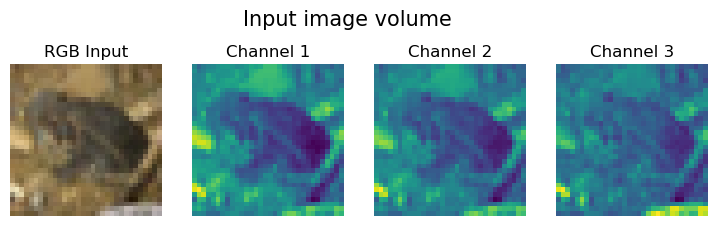

Input shape: (32, 32, 3) | Pooling size: (3, 3) | Stride: (3, 3)
Output shape: (10, 10, 3)


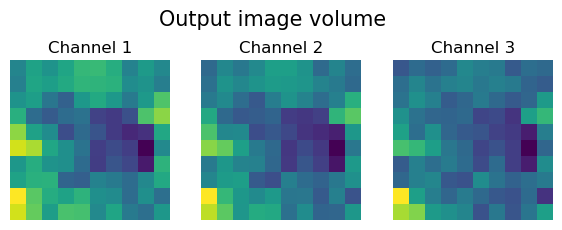

In [30]:
def test_pooling_layer():
    test_image = images[6][3]
    test_layer = PoolingLayer(input_size=test_image.shape, pooling_size=(3, 3), stride=(3, 3), pooling_fn=np.max)
    test_output = test_layer.forward_propagation(test_image)
    
    # Display the input image
    plt.figure(figsize=(9, 2.7))
    plt.suptitle(f'Input image volume', fontsize=15)

    plt.subplot(1, 4, 1)
    plt.imshow(test_image)
    plt.axis('off')
    plt.title('RGB Input')
    
    for i in range(test_image.shape[-1]):
        plt.subplot(1, 4, i+2)
        plt.imshow(test_image[..., i])
        plt.axis('off')
        plt.title(f'Channel {i+1}')
    plt.show()
    
    # Display the output
    print(f'Input shape: {test_image.shape} | Pooling size: {test_layer.pooling_size} | Stride: {test_layer.stride}')
    print(f'Output shape: {test_output.shape}')
    plt.figure(figsize=(7, 2.7))
    plt.suptitle(f'Output image volume', fontsize=15)
    
    for i in range(test_output.shape[-1]):
        plt.subplot(1, 3, i+1)
        plt.imshow(test_output[..., i])
        plt.axis('off')
        plt.title(f'Channel {i+1}')
    plt.show()

test_pooling_layer()

#### 5) Flatten (unraveling) function
The FlattenLayer class (extends FullyConnectedLayer class) transforms the input into a 1D array of desired size by firstly flattening the input and then applying a fully connected layer on it.

In [31]:
class FlattenLayer(FullyConnectedLayer):
    '''Flattens the input activation volume into a 1D vector of desired size'''
    def __init__(self, input_size: tuple[int, int, int], output_size: int) -> None:
        '''Initializes the flatten layer
        
        Args:
            input_size: The size of the input activation/image volume -> (W, H, C)
            output_size: The size of the flattened vector
        '''
        super().__init__(input_size[0] * input_size[1] * input_size[2], output_size, bias=False)
        self.input_size: tuple[int, int, int] = input_size
        self.output_size: int = output_size
        
    def forward_propagation(self, input: np.ndarray) -> np.ndarray:
        '''Flattens the input activation volume into a 1D vector'''
        input = np.atleast_3d(input)
        assert input.shape == self.input_size, f'Input must be of shape {self.input_size}'
        self.input = input.ravel() # Flatten the input
        self.output = super().forward_propagation(self.input) # Multiply the input with the weights
        return self.output
    
    def backward_propagation(self, output_error: np.ndarray) -> np.ndarray:
        '''Back propagates the output error through the flatten layer'''
        input_error = super().backward_propagation(output_error)
        return input_error.reshape(self.input_size)
    
    def update_parameters(self, learning_rate: float) -> None:
        '''Updates the weights of the flatten layer'''
        super().update_parameters(learning_rate)
        
    def __str__(self) -> str:
        return f'Flatten Layer(input_size={self.input_size}, output_size={self.output_size}, weights=\n{self.weights})'

In [32]:
def test_flatten_layer():
    img = np.arange(1, 61).reshape(4, 5, 3)
    print(img.shape)
    layer = FlattenLayer(input_size=(4, 5, 3), output_size=10)
    output = layer.forward_propagation(img)
    print(output)
    print(output.shape)
    assert output.shape == (1, 10)

test_flatten_layer()

(4, 5, 3)
[[ -39.317 -105.53   -35.516  -70.094   41.179  -62.286 -144.767  -83.852
   -62.329   15.226]]
(1, 10)


#### 6) Multilayer Perceprton (MLP) function (Fully Connected)
Builds on assignment-3 code

In [33]:
def MLP(input: np.ndarray, num_hidden_layers: int, layer_sizes: list[int], output_sz: int = 1, activation_fn: Callable = sigmoid) -> np.ndarray:
    '''Creates a multi layer perceptron with the given parameters and returns the forward propagated output for the given input
    
    Args:
        input: The input vector -> input.shape = (1, N)
        num_hidden_layers: The number of hidden layers in the MLP
        layer_sizes: The sizes of the hidden layers -> len(layer_sizes) = num_hidden_layers
        output_sz: The size of the output layer
        activation_fn: The activation function to be used for the hidden layers
        
    Returns:
        The output of the MLP -> output.shape = (1, 1)
    '''
    assert input.ndim == 2 and input.shape[0] == 1, 'Input must be a row vector'
    assert len(layer_sizes) == num_hidden_layers, 'Number of hidden layers must be equal to the length of layer_sizes'
    
    # Initialize the MLP
    classifier_ann = Network()
    classifier_ann.add(FullyConnectedLayer(input_size=input.shape[1], num_nodes=layer_sizes[0])) # Add the first hidden layer
    classifier_ann.add(ActivationLayer(activation_fn))
    for i in range(1, num_hidden_layers):
        classifier_ann.add(FullyConnectedLayer(input_size=layer_sizes[i-1], num_nodes=layer_sizes[i])) # Add the hidden layers
        classifier_ann.add(ActivationLayer(activation_fn))
    classifier_ann.add(FullyConnectedLayer(input_size=layer_sizes[-1], num_nodes=output_sz)) # Add the output layer
    
    # Forward propagate the input through the MLP
    output = classifier_ann.forward_propagation(input)
    
    # Return the output with and without the softmax activation
    return output, softmax(output)

In [34]:
def test_mlp():
    input = np.array([[1, 0, 1]])
    output, output_softmax = MLP(input, num_hidden_layers=2, layer_sizes=[4, 5], output_sz=3, activation_fn=sigmoid)
    print(f'Output: {output}')
    print(f'Output Softmax: {output_softmax}')

test_mlp()

Output: [[-0.571  0.044  0.558]]
Output Softmax: [[0.168 0.311 0.52 ]]


#### 7) Feed-forward path

In [35]:
# Creating a Convolutional Neural Network using the above layers
cnn = Network()

# Add the layers
# Convolutional layer with input image of size (32, 32, 3), 16 kernels of size (3, 3, 3), and sigmoid activation
cnn.add(ConvolutionLayer(input_size=(32, 32, 3), num_kernels=16, kernel_size=(3, 3, 3), stride=(1, 1), padding=(1, 1)))
cnn.add(ActivationLayer(sigmoid))

# Max pooling layer with pooling window size (2, 2) and stride (2, 2)
cnn.add(PoolingLayer(input_size=(32, 32, 16), pooling_size=(2, 2), stride=(2, 2), pooling_fn=np.max))

# Convolutional layer with 8 kernels of size (3, 3, 16), and sigmoid activation (C_2 = 16)
cnn.add(ConvolutionLayer(input_size=(16, 16, 16), num_kernels=8, kernel_size=(3, 3, 16), stride=(1, 1), padding=(1, 1)))
cnn.add(ActivationLayer(sigmoid))

# Max pooling layer with pooling window size (2, 2) and stride (2, 2)
cnn.add(PoolingLayer(input_size=(16, 16, 8), pooling_size=(2, 2), stride=(2, 2), pooling_fn=np.max))

# Flattening layer with output size 32
cnn.add(FlattenLayer(input_size=(8, 8, 8), output_size=32)) # Internal matrix converts the flattened 512 vector to a 32 vector

# MLP with 1 hidden layer of size 16, sigmoid activation, and output layer of size 10
cnn.add(FullyConnectedLayer(input_size=32, num_nodes=16))
cnn.add(ActivationLayer(sigmoid))
cnn.add(FullyConnectedLayer(input_size=16, num_nodes=10))

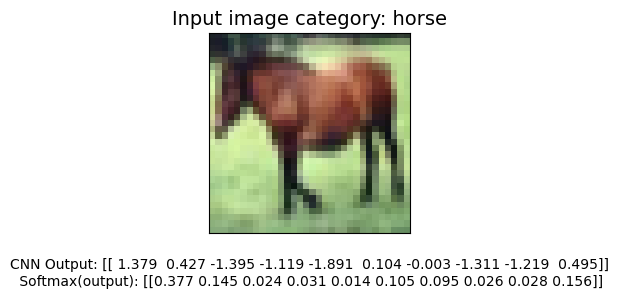


Network with 10 layers:
Layer 1: Convolution Layer(input_size=(32, 32, 3), num_kernels=16, kernel_size=(3, 3, 3), stride=(1, 1), padding=(1, 1), kernels=
[[[[ 0.241 -0.279 -0.155]
   [ 0.067  0.139  0.322]
   [ 0.079 -0.236  0.184]]

  [[ 0.437  0.478  0.011]
   [-0.261  0.306 -0.348]
   [ 0.255 -0.267  0.237]]

  [[ 0.073  0.345 -0.288]
   [ 0.139  0.079  0.31 ]
   [ 0.279 -0.126 -0.435]]]


 [[[-0.18   0.247 -0.243]
   [-0.267  0.113  0.356]
   [ 0.084  0.314 -0.002]]

  [[ 0.477 -0.311 -0.482]
   [-0.363  0.449  0.457]
   [-0.408 -0.333  0.447]]

  [[-0.309  0.4   -0.168]
   [ 0.163 -0.352 -0.237]
   [ 0.002  0.113  0.023]]]


 [[[ 0.293  0.241 -0.371]
   [-0.228 -0.383 -0.25 ]
   [-0.103 -0.122  0.177]]

  [[ 0.369 -0.392  0.134]
   [-0.207 -0.038 -0.01 ]
   [-0.486  0.141  0.218]]

  [[-0.38   0.385 -0.322]
   [ 0.03   0.107  0.251]
   [-0.405  0.176  0.367]]]


 [[[ 0.111  0.446 -0.151]
   [-0.253 -0.461  0.225]
   [ 0.123  0.412 -0.173]]

  [[ 0.261  0.148 -0.43 ]
   [-0.398 -0

array([[ 1.379,  0.427, -1.395, -1.119, -1.891,  0.104, -0.003, -1.311,
        -1.219,  0.495]])

In [36]:
def test_feed_forward_path(i: int, verbose: bool = False):
    # Verify that the CNN accepts an image and outputs a vector
    test_image = images[i][0]
    output = cnn.forward_propagation(test_image)
    assert output.ndim == 2 and output.shape[0] == 1 and output.shape[1] == 10, 'CNN must output a row vector of size 10'
    
    # Display the input image
    plt.figure(figsize=(10, 2.6))
    plt.imshow(test_image)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Input image category: {label_names[i]}', fontsize=14)
    plt.text(0.5, -0.2, f'CNN Output: {output}\n Softmax(output): {softmax(output)}', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)
    plt.show()

    # Print the CNN
    if verbose:
        print(cnn)
        print(f'CNN output shape: {output.shape}')
    return output
    
test_feed_forward_path(7, verbose=True)

#### 8) Examples

##### a) Choose an image from each of the 10 classes and display the output vector for each case. Do you see any trend in the output vectors?

/tmp/ipykernel_253053/2273399325.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


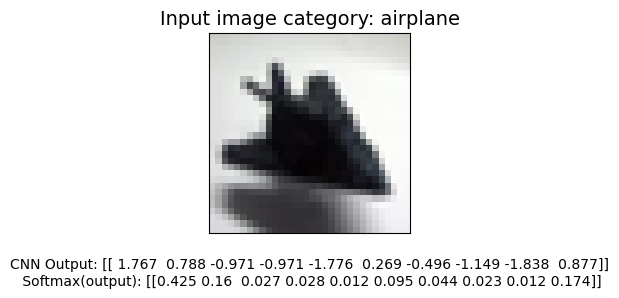

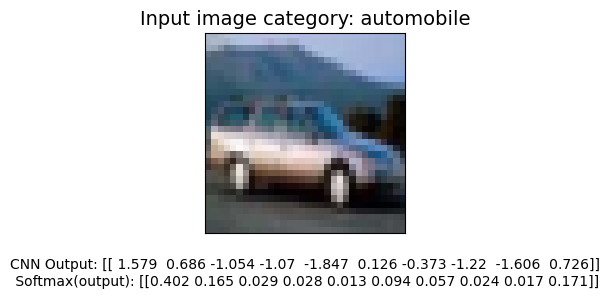

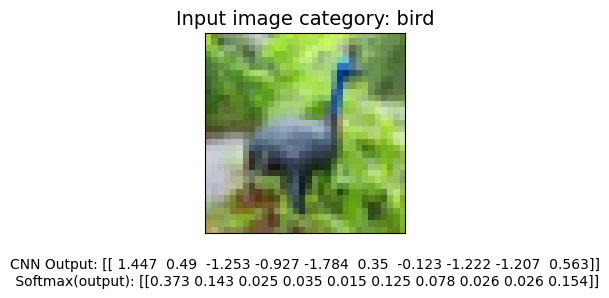

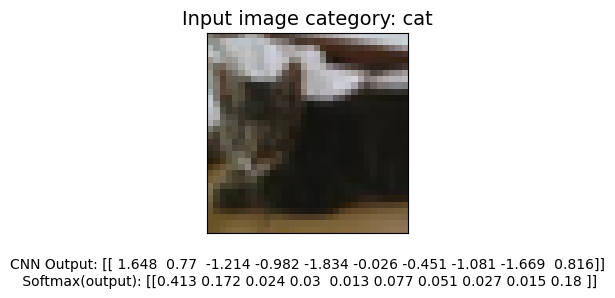

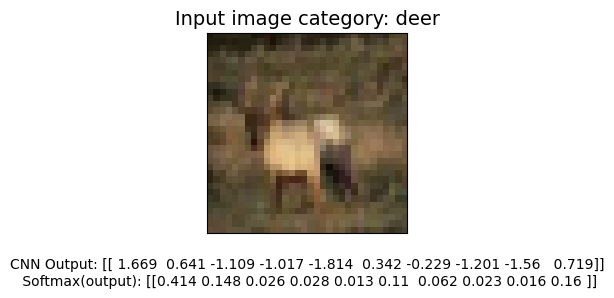

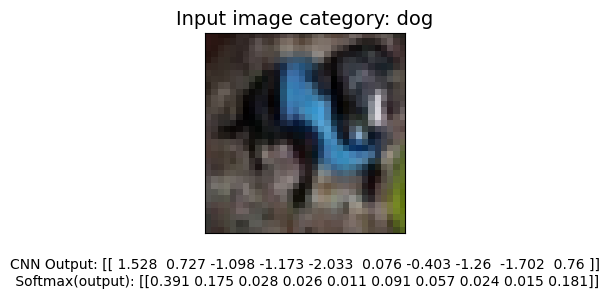

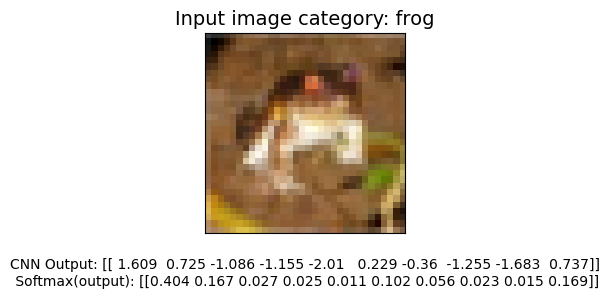

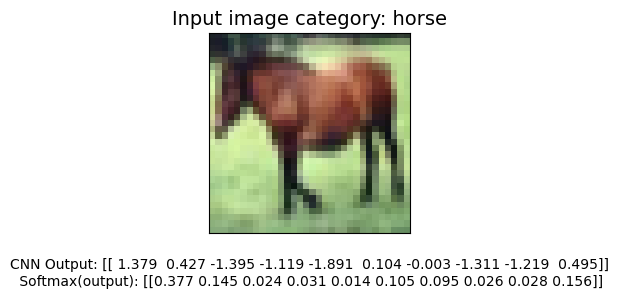

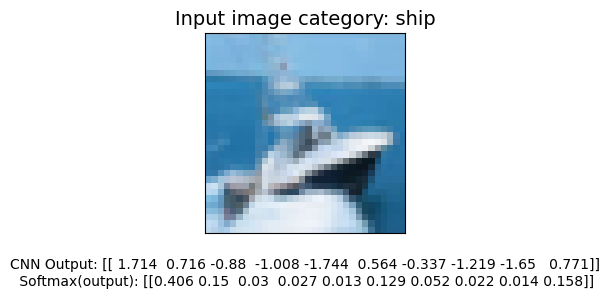

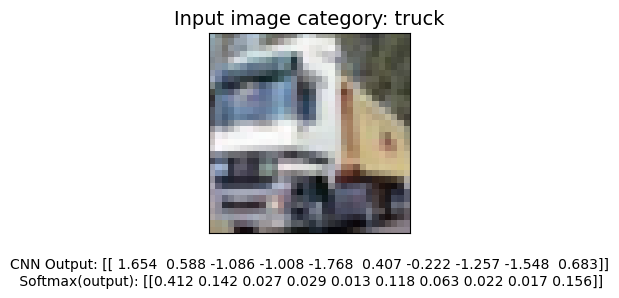

Outputs: 
[[[0.425 0.16  0.027 0.028 0.012 0.095 0.044 0.023 0.012 0.174]]

 [[0.402 0.165 0.029 0.028 0.013 0.094 0.057 0.024 0.017 0.171]]

 [[0.373 0.143 0.025 0.035 0.015 0.125 0.078 0.026 0.026 0.154]]

 [[0.413 0.172 0.024 0.03  0.013 0.077 0.051 0.027 0.015 0.18 ]]

 [[0.414 0.148 0.026 0.028 0.013 0.11  0.062 0.023 0.016 0.16 ]]

 [[0.391 0.175 0.028 0.026 0.011 0.091 0.057 0.024 0.015 0.181]]

 [[0.404 0.167 0.027 0.025 0.011 0.102 0.056 0.023 0.015 0.169]]

 [[0.377 0.145 0.024 0.031 0.014 0.105 0.095 0.026 0.028 0.156]]

 [[0.406 0.15  0.03  0.027 0.013 0.129 0.052 0.022 0.014 0.158]]

 [[0.412 0.142 0.027 0.029 0.013 0.118 0.063 0.022 0.017 0.156]]]


In [37]:
outputs = []
for i in range(10):
    outputs.append(softmax(test_feed_forward_path(i)))
    
print(f'Outputs: \n{np.array(outputs)}')

No, their is no trend in the output and it is more or less completely random. This is because the network is not trained yet.

##### b) Does a randomly initialized network show any discriminability?
No, as discussed above, the network is not trained yet, so it is not able to discriminate between the classes, and the probability of each class is almost the same.

In [38]:
# Get the bottleneck layer outputs
flattened_outputs = []
for category in range(10):
    for img in images[category][:3]:
        cnn.forward_propagation(img)
        flattened_outputs.append(cnn.layers[-4].output)
        
flattened_outputs = np.array(flattened_outputs).squeeze()
print(f'Flattened outputs shape: {flattened_outputs.shape}')

/tmp/ipykernel_253053/2273399325.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Flattened outputs shape: (30, 32)


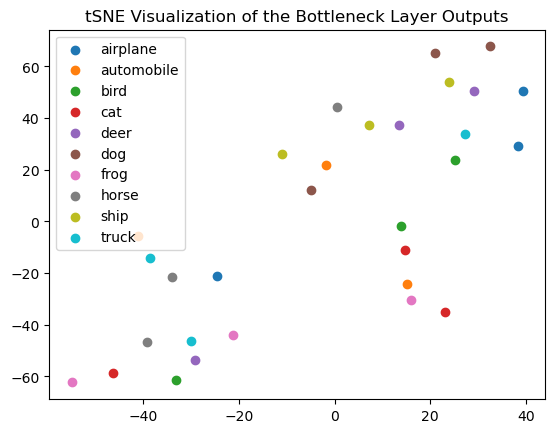

In [39]:
# Plot tSNE visualization
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(flattened_outputs)
for i in range(10):
    plt.scatter(X_embedded[3*i:3*(i+1), 0], X_embedded[3*i:3*(i+1), 1], label = label_names[i])
    plt.legend()

plt.title('tSNE Visualization of the Bottleneck Layer Outputs')
plt.show()